# Convolutional Neural Network

In this tutorial, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use MNIST and Cat vs Dog dataset.

See http://yann.lecun.com/exdb/mnist <br>
See https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
%load_ext autoreload
%autoreload 2

In [2]:
# %load _utils
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['sparse_categorical_accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_sparse_categorical_accuracy'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### 1. Load MNIST dataset 

In [3]:
### Load dataset ###
(X_train,y_train), (X_test,y_test) = mnist.load_data()
####################

In [4]:
X_train.shape

(60000, 28, 28)

### 2. Preprocess data 
Use Min-Max (0,1) scaling 

In [5]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    data = data.astype('float32')/255.
    return data

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [6]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [7]:
BATCH_SIZE = 32

### 3. Build a convolutional neural network 


In [8]:
cnn = models.Sequential()
cnn.add(layers.Input(shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,)))
cnn.add(layers.Conv2D(filters=32,           # 32 filters
                      kernel_size=3,        # 3x3 filter/kernel, stride=(1,1) (default)
                      padding='same',       # No padding
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))  # Max pooling with 2x2 filter 
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='elu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(10,activation='softmax',            
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_1 (MaxPooling2D)       │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool_2 (MaxPooling2D)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connect_1 (Dense)         │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,634 (3.32 MB)

 Trainable params: 870,634 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

### 4. Trainig CNN Model
- Take 20% of the data for the validation set. 
- Train for 20 epochs and save the intemediate model. 

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0,stratify=y_train)

In [10]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr20.keras')


Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.4284 - sparse_categorical_accuracy: 0.8829 - val_loss: 0.0495 - val_sparse_categorical_accuracy: 0.9839
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9763 - val_loss: 0.0550 - val_sparse_categorical_accuracy: 0.9844
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - loss: 0.0642 - sparse_categorical_accuracy: 0.9815 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9852
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - loss: 0.0601 - sparse_categorical_accuracy: 0.9835 - val_loss: 0.0461 - val_sparse_categorical_accuracy: 0.9884
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.0363 - val_sparse_categorical_accuracy: 0.9902
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.0422 - val_sparse_categorical_accuracy:

```verbose=False``` will show you nothing (silent)

```verbose=TURE``` will show you an animated progress bar like this:
[==============================]



Continuing training ...

Last train accuracy: 0.9945416450500488
Last validation accuracy: 0.9909166693687439


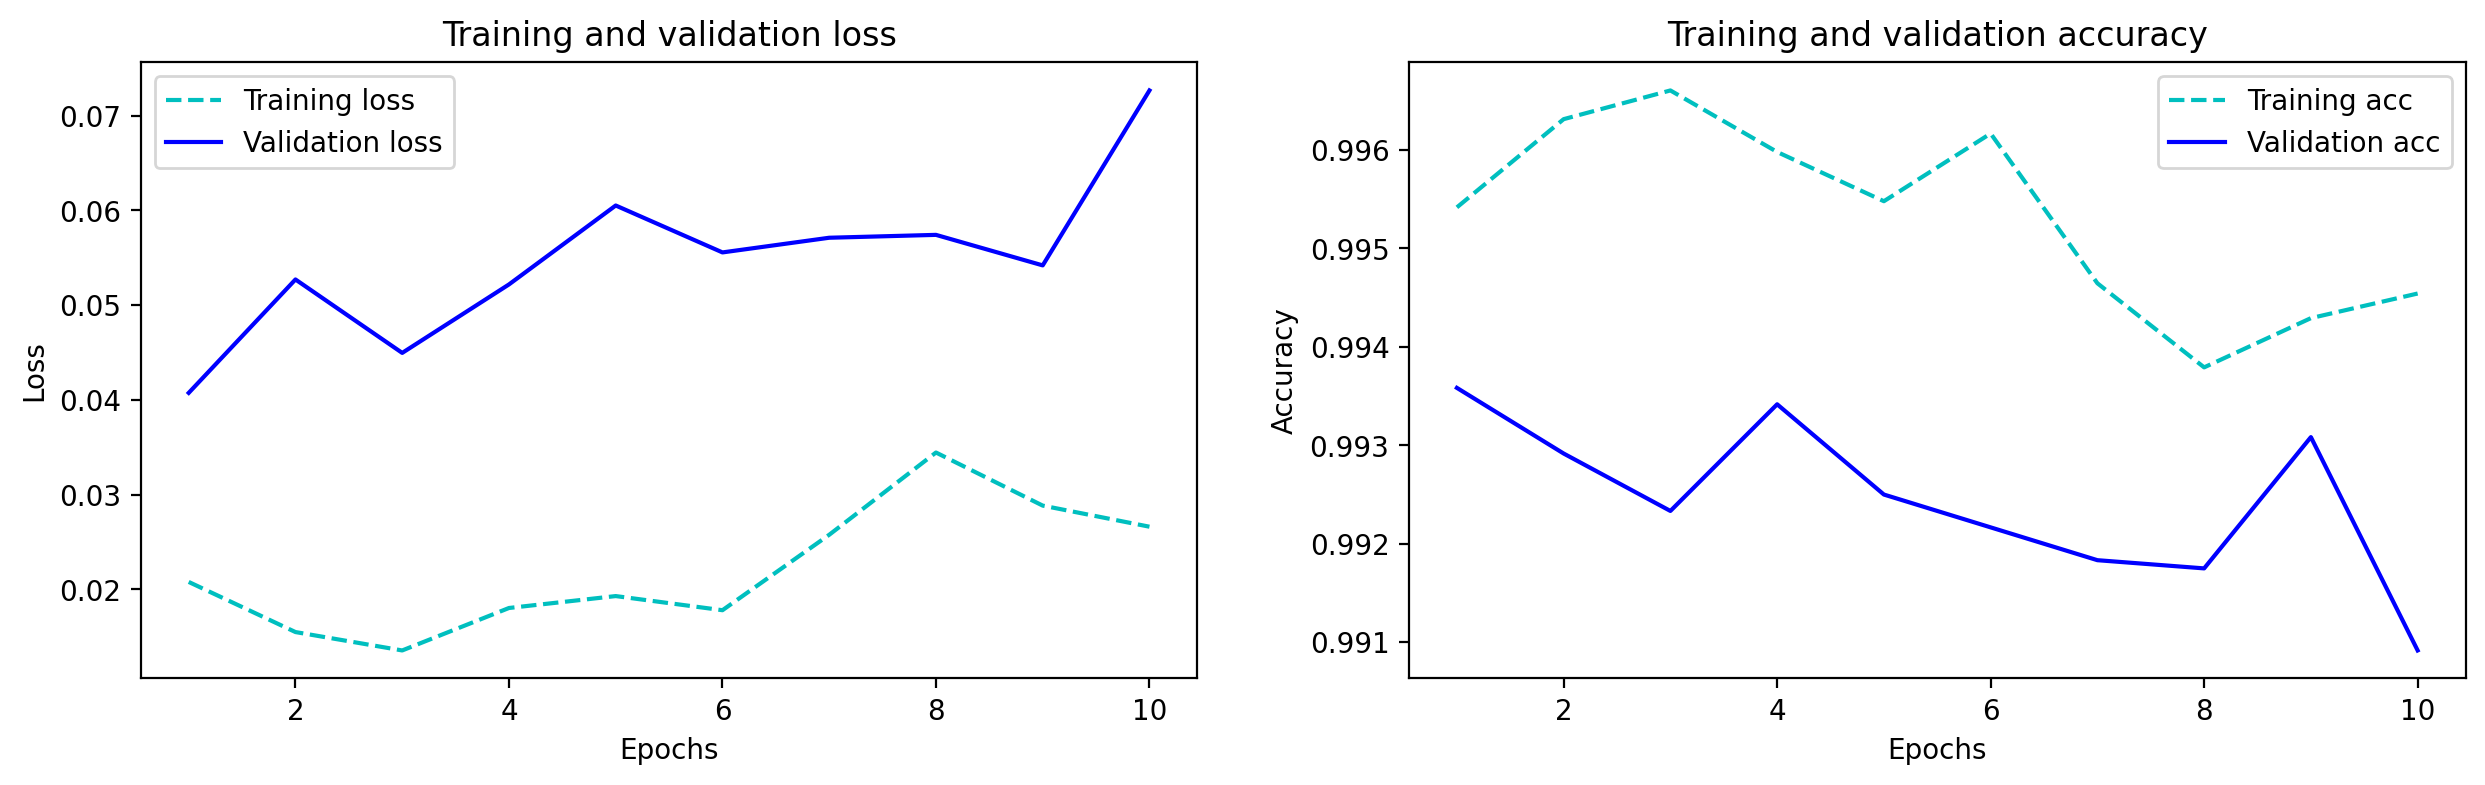

In [11]:
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=False)
cnn.save('baseline_model_itr10_verboseFalse.keras')
show_result(history)

Train model with early stopping

Last train accuracy: 0.9962916374206543
Last validation accuracy: 0.9933333396911621


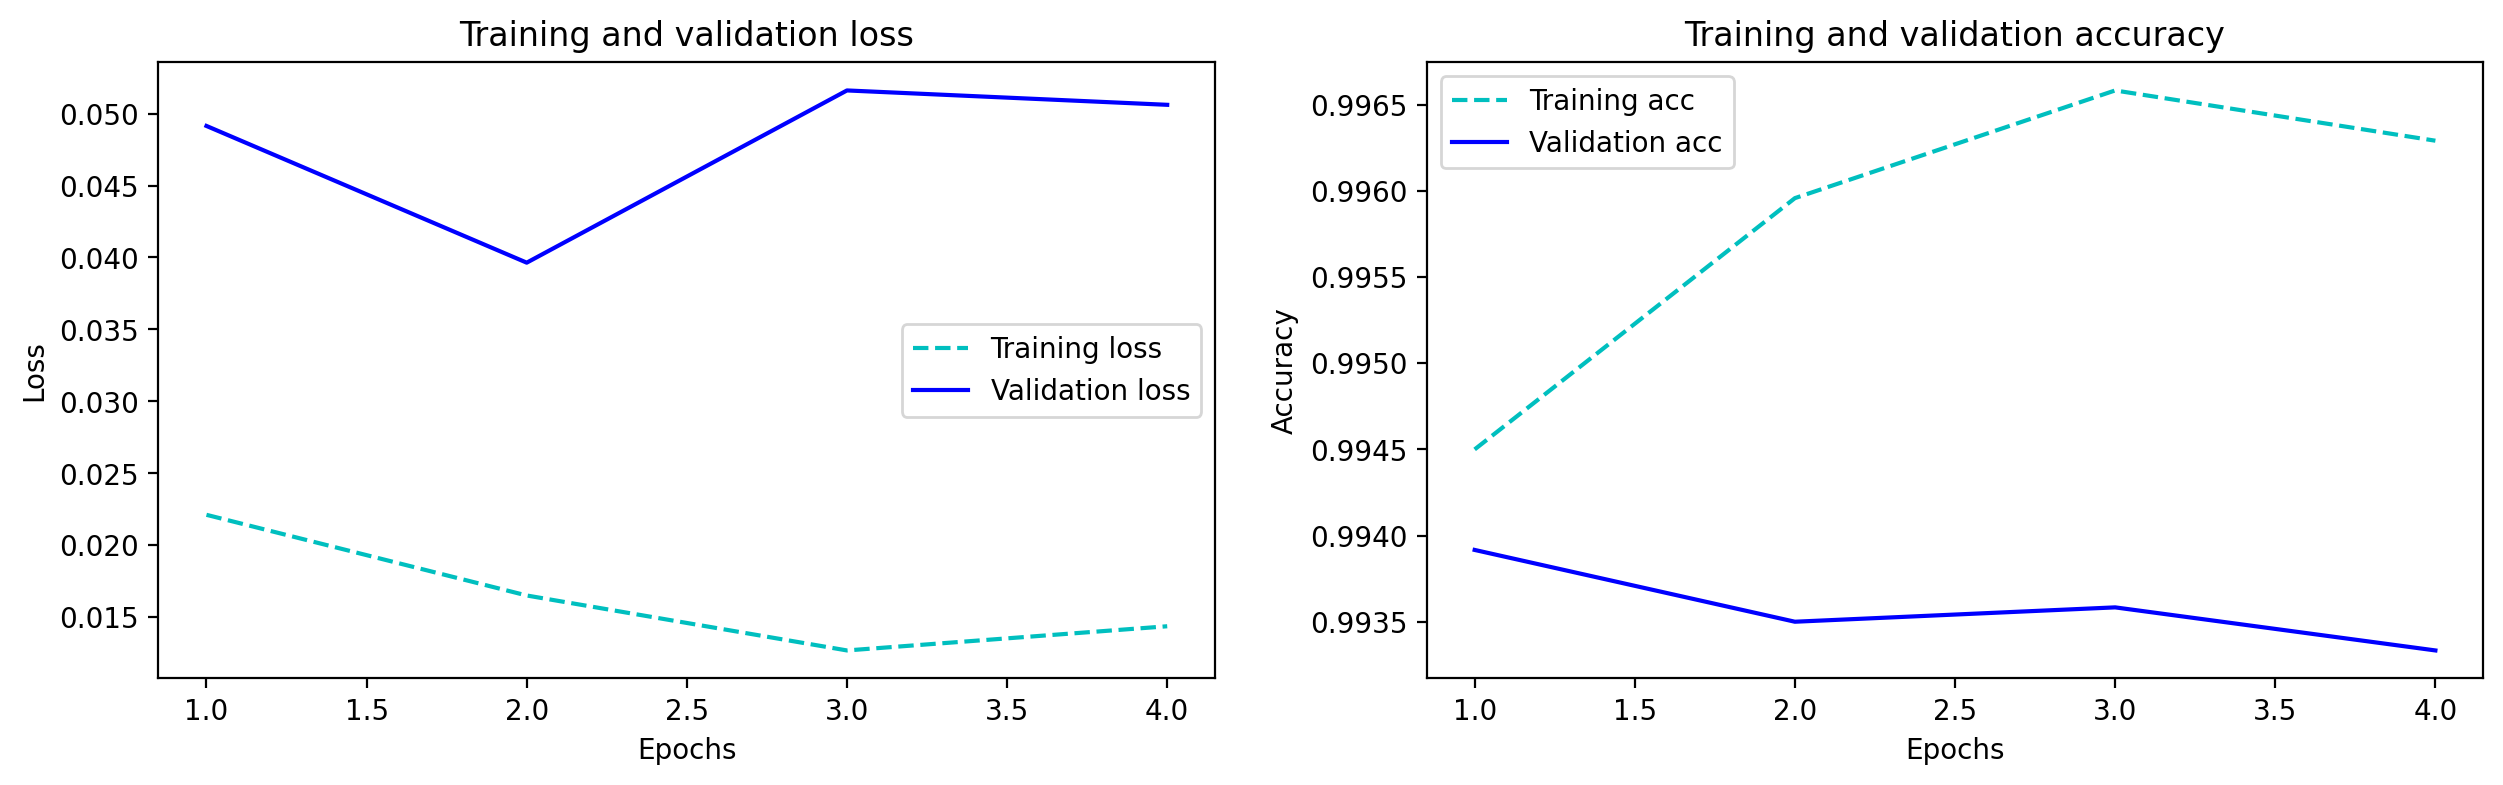

In [12]:
cnn = models.load_model('baseline_model_itr20.keras')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stop],
                  verbose=False)
cnn.save('baseline_model_itr10_earlystop.keras')
show_result(history)

### 5. Evaluate your model 
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [13]:
pred_class = evaluation_report(cnn,X_test,y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1132    1    0    0    0    1    1    0    0]
 [   1    0 1023    1    0    0    0    6    1    0]
 [   0    0    0 1009    0    1    0    0    0    0]
 [   0    1    0    0  970    0    2    0    0    9]
 [   1    0    0    4    0  884    3    0    0    0]
 [   1    1    0    0    1    1  953    0    1    0]
 [   0    2    1    0    1    0    0 1021    1    2]
 [   1    0    1    1    0    1    0    1  966    3]
 [   1    0    0    2    5    2    0    1    4  994]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99      

### 5.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(69, 28, 28)


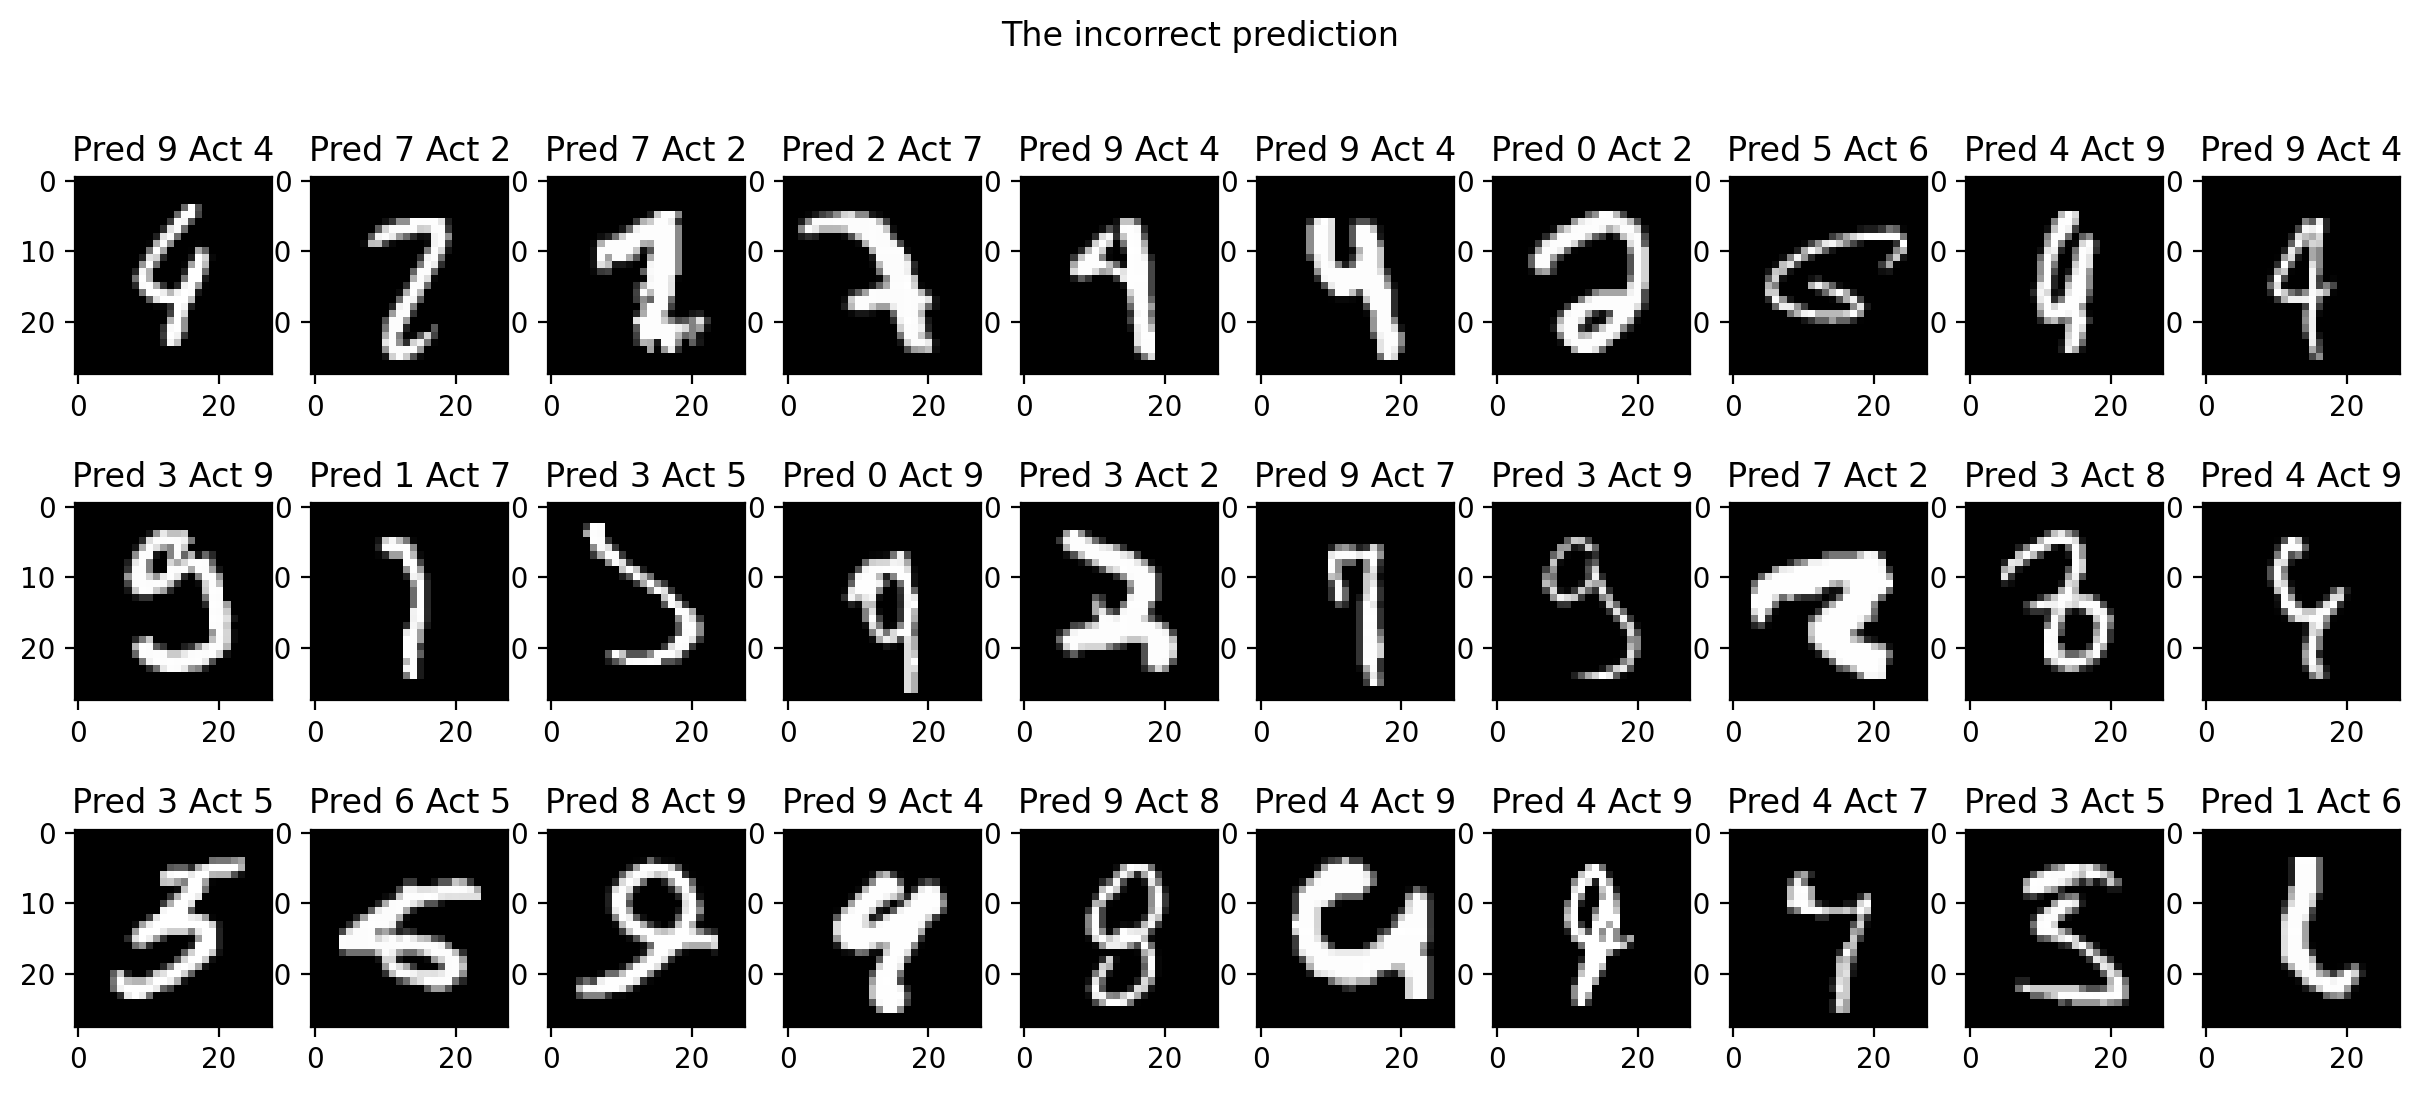

In [14]:
show_false_prediction(pred_class, X_test, y_test)

**Discuss the results**

*Discussion*